In [34]:
import scanpy as sc
from scprint2 import scPRINT2
from scdataloader import Preprocessor
from scdataloader.utils import load_genes
import numpy as np

import anndata as ad
from huggingface_hub import hf_hub_download
import lamindb as ln

from scprint2.tasks import Embedder, Generate
import pandas as pd

from scprint2.utils.utils import volcano
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
from anndata import AnnData
import bionty as bt
import ot

import gseapy as gp

%load_ext autoreload
%autoreload 2

import torch
import scipy.sparse

torch.set_float32_matmul_precision("medium")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# ! uv pip install POT

In [2]:
LOC = "/pasteur/appa/scratch/jkalfon/data/spcrint_data/"  # "./normalize_log/"

# human <- mouse

see the cross-species-embedding notebook for how we download the data from this
benchmark paper


## preprocessing


In [ ]:
len(set(human.var.index) & set(mouse.var.index.str.upper()))

13090

In [ ]:
human = sc.read(LOC + "task4_human.h5ad")
mouse = sc.read(LOC + "task4_mouse.h5ad")

In [4]:
def revert_to_raw(adata):
    res = adata.X
    res = np.exp(res) - 1
    res = (
        (res.T / np.array([res[i][res[i] != 0].min() for i in range(res.shape[0])]))
        .round()
        .T
    )  # .sum()
    adata.X = res
    return adata

In [6]:
human.obs["organism_ontology_term_id"] = "NCBITaxon:9606"
mouse.obs["organism_ontology_term_id"] = "NCBITaxon:10090"

In [7]:
mouse = revert_to_raw(mouse)
human = revert_to_raw(human)

In [5]:
mouse.var.index = mouse.var.index.str.upper()
human = human[:, human.var.index.isin(mouse.var.index)]
mouse = mouse[:, mouse.var.index.isin(human.var.index)]

In [ ]:
human.X = scipy.sparse.csr_matrix(human.X)
mouse.X = scipy.sparse.csr_matrix(mouse.X)

In [ ]:
preprocessor = Preprocessor(
    is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False
)
human = preprocessor(human.copy())
mouse = preprocessor(mouse.copy())

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 52816 renamining
filtered out 5 cells, 52811 renamining
Removed 4285 genes not known to the ontology
Removed 0 duplicate genes
Added 53430 genes in the ontology but not present in the dataset
starting QC
Seeing 5700 outliers (10.79% of total dataset):
done
AnnData object with n_obs × n_vars = 52811 × 70116
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'n_genes', 'n_counts', 'sample', 'stage', 'celltype', 'batch', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'n_cells', 'uid', 'symbol', 'biotype', 'organism_id', 'branch_id', 'mt', 'ribo', 'hb', 'organism

In [9]:
additional = {
    "Loop of Henle": "CL:1000909",
    "Sinusoidal endothelial cell ": "CL:0002262",
    "Endothelial cell (APC)": "CL:0000115",
    "stromal cell": "CL:0000499",
    "Epithelial cell (intermediated)": "CL:0000066",
    "Proximal tubule cellAscending loop of Henle": "CL:1000909",
    "Intercalated cells of collecting duct": "CL:0005010",
    "Erythroid cell": "CL:0000764",
    "Microglia": "CL:0000129",
    "Distal convoluted tubule": "CL:1000849",
    "Connecting tubule cell": "CL:1000768",
}

res = (
    bt.CellType.standardize(
        mouse.obs.celltype.value_counts().keys(),
        return_mapper=True,
        return_field="ontology_id",
    )
    | additional
)
res

{'Fibroblast': 'CL:0000057',
 'Endothelial cell': 'CL:0000115',
 'Macrophage': 'CL:0000235',
 'Astrocyte': 'CL:0000127',
 'Oligodendrocyte': 'CL:0000128',
 'Epithelial cell': 'CL:0000066',
 'Dendritic cell': 'CL:0000451',
 'Smooth muscle cell': 'CL:0000192',
 'Monocyte': 'CL:0000576',
 'Neutrophil': 'CL:0000775',
 'Hepatocyte': 'CL:0000182',
 'Plasma cell': 'CL:0000786',
 'Cardiomyocyte': 'CL:0000746',
 'Neural progenitor cell': 'CL:0011020',
 'Erythroblast': 'CL:0000765',
 'Mast cell': 'CL:0000097',
 'Ependymal cell': 'CL:0000065',
 'Mesenchymal cell': 'CL:0008019',
 'Basal cell': 'CL:0000646',
 'Myocyte': 'CL:0000187',
 'Enterocyte': 'CL:0000584',
 'Unknown': 'unknown',
 'Megakaryocyte': 'CL:0000556',
 'Chondrocyte': 'CL:0000138',
 'Goblet cell': 'CL:0000160',
 'Striated muscle cell': 'CL:0000737',
 'T cell': 'CL:0000084',
 'B cell': 'CL:0000236',
 'Loop of Henle': 'CL:1000909',
 'Sinusoidal endothelial cell ': 'CL:0002262',
 'Endothelial cell (APC)': 'CL:0000115',
 'stromal cell': '

In [10]:
mouse.obs["cell_type_ontology_term_id"] = [
    res.get(i, "unknown") for i in mouse.obs["celltype"].values
]

In [11]:
additional = {
    "Loop of Henle": "CL:1000909",
    "Sinusoidal endothelial cell ": "CL:0002262",
    "Endothelial cell (APC)": "CL:0000115",
    "stromal cell": "CL:0000499",
    "Epithelial cell (intermediated)": "CL:0000066",
}

res = (
    bt.CellType.standardize(
        human.obs.celltype.value_counts().keys(),
        return_mapper=True,
        return_field="ontology_id",
    )
    | additional
)
res

{'Smooth muscle cell': 'CL:0000192',
 'Monocyte': 'CL:0000576',
 'Epithelial cell': 'CL:0000066',
 'Intercalated cell': 'CL:0005010',
 'Macrophage': 'CL:0000235',
 'Dendritic cell': 'CL:0000451',
 'Stromal cell': 'CL:0000499',
 'Neutrophil': 'CL:0000775',
 'Mast cell': 'CL:0000097',
 'Fibroblast': 'CL:0000057',
 'Endothelial cell': 'CL:0000115',
 'Ureteric bud cell': 'CL:4030066',
 'Goblet cell': 'CL:0000160',
 'Myeloid cell': 'CL:0000763',
 'Stratified epithelial cell': 'CL:0000079',
 'Basal cell': 'CL:0000646',
 'T cell': 'CL:0000084',
 'B cell': 'CL:0000236',
 'Loop of Henle': 'CL:1000909',
 'Sinusoidal endothelial cell ': 'CL:0002262',
 'Endothelial cell (APC)': 'CL:0000115',
 'stromal cell': 'CL:0000499',
 'Epithelial cell (intermediated)': 'CL:0000066'}

In [ ]:
human.obs["cell_type_ontology_term_id"] = [
    res.get(i, "unknown") for i in human.obs["celltype"].values
]

In [ ]:
human.write(LOC + "proc_hum.h5ad")
mouse.write(LOC + "proc_mouse.h5ad")

... storing 'organism_ontology_term_id' as categorical
... storing 'cell_type_ontology_term_id' as categorical
... storing 'symbol' as categorical
... storing 'biotype' as categorical
... storing 'organism' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'cell_type_ontology_term_id' as categorical
... storing 'symbol' as categorical
... storing 'biotype' as categorical
... storing 'organism' as categorical


In [3]:
human = sc.read(LOC + "proc_hum.h5ad")
mouse = sc.read(LOC + "proc_mouse.h5ad")

## re-generate those cell types with mouse genes and compare


In [4]:
# model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
# )
# model_checkpoint_file = ../data/
model_checkpoint_file = "../models/ji9krimq.ckpt"
# w937u4o1.ckpt'
# da6ao55o.ckpt # 649
# 1lzuxvg0.ckpt # 677

In [5]:
model = scPRINT2.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)
model = model.to("cuda")

FYI: scPrint is not attached to a `Trainer`.


In [7]:
# we embed the human
embed = Embedder(
    how="random expr",
    max_len=2600,
    num_workers=8,
    pred_embedding=["all"],
    doplot=False,
    save_every=20_000,
)
n_adata, _ = embed(model, human)

[autoreload of scprint.tasks failed: Traceback (most recent call last):
  File "/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
  File "/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 580, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/pasteur/appa/homes/jkalfon/.local/share/uv/python/cpython-3.11.11-linux-x86_64-gnu/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/pasteur/appa/homes/jkalfon/scPRINT/scprint/tasks/__init__.py", line 7, in <module>
    from .impute import Imputerqq
ImportError: cannot import name

not on wandb, could not set name


 38%|███▊      | 312/826 [03:07<04:54,  1.75it/s]

logging
logging the anndata
AnnData object with n_obs × n_vars = 20032 × 20004
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_other', 'scprint_emb_cell_type_ontology_term_id', 'scprint_emb_tissue_ontology_term_id', 'scprint_emb_disease_ontology_term_id', 'scprint_emb_age_group', 'scprint_emb_assay_ontology_term_id', 'scprint_emb_self_reported_ethnicity_ontology_term_id', 'scprint_emb_sex_ontology_term_id', 'scprint_emb_organism_ontology_term_id', 'scprint_emb_cell_culture'
    layers: 'scprint_mu', 's

 76%|███████▌  | 625/826 [06:24<01:55,  1.74it/s]

logging
logging the anndata
AnnData object with n_obs × n_vars = 20032 × 20004
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_other', 'scprint_emb_cell_type_ontology_term_id', 'scprint_emb_tissue_ontology_term_id', 'scprint_emb_disease_ontology_term_id', 'scprint_emb_age_group', 'scprint_emb_assay_ontology_term_id', 'scprint_emb_self_reported_ethnicity_ontology_term_id', 'scprint_emb_sex_ontology_term_id', 'scprint_emb_organism_ontology_term_id', 'scprint_emb_cell_culture'
    layers: 'scprint_mu', 's

100%|██████████| 826/826 [08:38<00:00,  1.59it/s]


logging the anndata
AnnData object with n_obs × n_vars = 12747 × 20004
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_other', 'scprint_emb_cell_type_ontology_term_id', 'scprint_emb_tissue_ontology_term_id', 'scprint_emb_disease_ontology_term_id', 'scprint_emb_age_group', 'scprint_emb_assay_ontology_term_id', 'scprint_emb_self_reported_ethnicity_ontology_term_id', 'scprint_emb_sex_ontology_term_id', 'scprint_emb_organism_ontology_term_id', 'scprint_emb_cell_culture'
    layers: 'scprint_mu', 'scprint_t

In [ ]:
n_adata.write_h5ad(LOC + "emb_hum.h5ad")

In [19]:
n_adata = sc.read_h5ad(LOC + "emb_hum.h5ad")

In [8]:
# we don't have human brain tissue
mouse = mouse[mouse.obs["orig.ident"] != "mouse_Brain"]

In [9]:
# we embed the mouse
embed = Embedder(
    how="random expr",
    max_len=2600,
    num_workers=8,
    pred_embedding=["all"],
    doplot=False,
)
sup, _ = embed(model, mouse)  # np.random.choice(mouse.shape[0], 1000, replace=False)])

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 429/429 [04:14<00:00,  1.68it/s]


logging the anndata
AnnData object with n_obs × n_vars = 27436 × 21550
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_other', 'scprint_emb_cell_type_ontology_term_id', 'scprint_emb_tissue_ontology_term_id', 'scprint_emb_disease_ontology_term_id', 'scprint_emb_age_group', 'scprint_emb_assay_ontology_term_id', 'scprint_emb_self_reported_ethnicity_ontology_term_id', 'scprint_emb_sex_ontology_term_id', 'scprint_emb_organism_ontology_term_id', 'scprint_emb_cell_culture'
    layers: 'scprint_mu', 'scprint_t

In [ ]:
sup.write_h5ad(LOC + "emb_mouse.h5ad")

In [33]:
sup = sc.read_h5ad(LOC + "emb_mouse.h5ad")

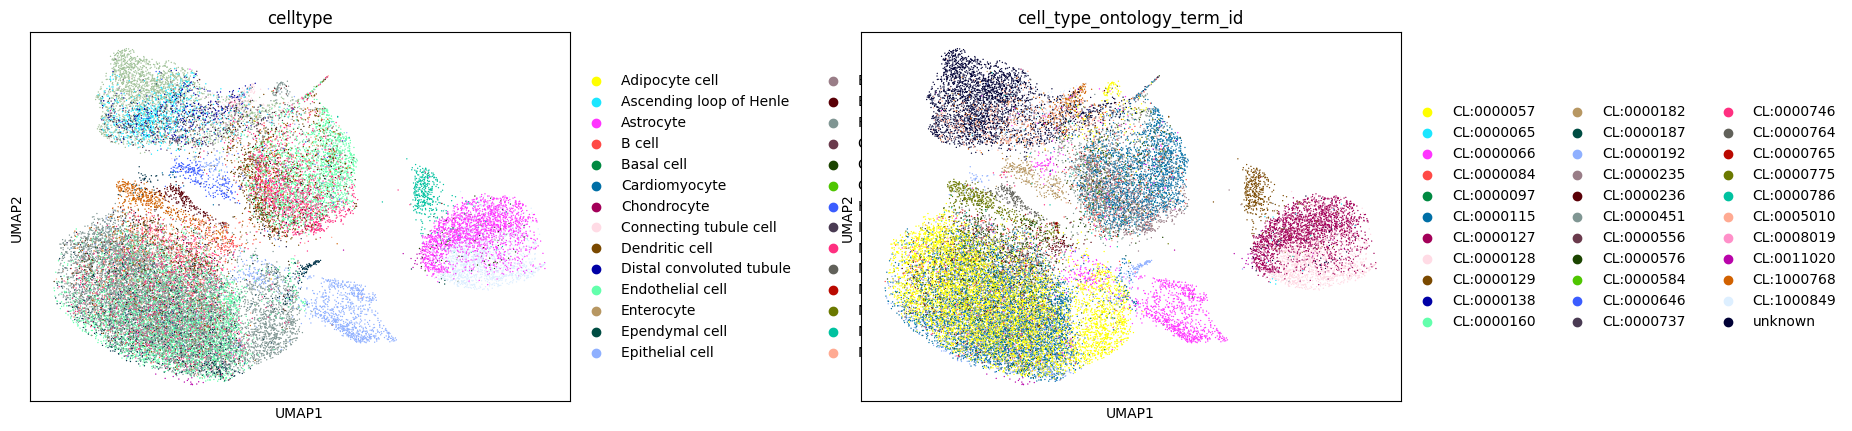

In [15]:
sc.pp.neighbors(sup, use_rep="scprint_emb_organism_ontology_term_id")
sc.tl.umap(sup)
sc.pl.umap(sup, color=["celltype", "cell_type_ontology_term_id"], wspace=0.4)

### move the human organism cell embedding into the mouse

and we select genes to work on


In [10]:
sup.obsm["scprint_emb_organism_ontology_term_id"] = np.tile(
    n_adata.obsm["scprint_emb_organism_ontology_term_id"].mean(0), (sup.shape[0], 1)
)

In [11]:
human = human[
    :,
    human.var.symbol.isin(mouse.var.symbol.str.upper())
    & human.var.index.isin(model.genes),
]

In [12]:
sc.pp.highly_variable_genes(human, n_top_genes=5000, flavor="seurat_v3")

In [13]:
rand = np.random.choice(
    min(human.X.shape[0], mouse.X.shape[0]), size=10_000, replace=False
)

In [14]:
human = human[rand, human.var["highly_variable"]]
mouse = mouse[
    rand,
    mouse.var.symbol.str.upper().isin(
        human.var.symbol[human.var["highly_variable"]].tolist()
    )
    & mouse.var.index.isin(model.genes),
]
mouse = mouse[:, ~mouse.var.symbol.duplicated(keep="first")]
human = human[:, human.var.symbol.isin(mouse.var.symbol.str.upper())]
mouse = mouse[:, mouse.var.symbol.str.upper().argsort()]
human = human[:, human.var.symbol.argsort()]

In [15]:
genes = human.var.index.tolist()
len(genes)

4990

# we do the generative part


In [16]:
elems = [
    "scprint_emb_age_group",
    "scprint_emb_assay_ontology_term_id",
    "scprint_emb_cell_culture",
    "scprint_emb_cell_type_ontology_term_id",
    "scprint_emb_disease_ontology_term_id",
    "scprint_emb_organism_ontology_term_id",
    "scprint_emb_other",
    "scprint_emb_self_reported_ethnicity_ontology_term_id",
    "scprint_emb_sex_ontology_term_id",
    "scprint_emb_tissue_ontology_term_id",
]

In [17]:
generator = Generate(genelist=genes, batch_size=32)
pred = generator(model, sup)

not on wandb, could not set name


100%|██████████| 858/858 [13:29<00:00,  1.06it/s]


In [ ]:
pred.write_h5ad(LOC + "pred_as_human.h5ad")

In [32]:
pred = sc.read_h5ad(LOC + "pred_as_human.h5ad")

In [63]:
human.X.sum(1).mean(), mouse.X.sum(1).mean(), pred.X.sum(1).mean()

(np.float32(250.9618), np.float32(237.9519), np.float32(864.9844))

In [23]:
human.X.shape, mouse.X.shape, pred[rand].X.shape

((10000, 4990), (10000, 4990), (10000, 4990))

# (optional) benchmarks


In [25]:
res = ot.solve_sample(
    torch.Tensor(pred[rand].X).to(device="cuda"),
    torch.Tensor(human.X.todense()).to(device="cuda"),
    reg=0.1,
)
res.value

tensor(2367.0830, device='cuda:0')

In [19]:
res = ot.solve_sample(
    torch.Tensor(human.X.todense()).to(device="cuda"),
    torch.Tensor(mouse.X.todense()).to(device="cuda"),
    reg=0.1,
)
res.value

tensor(2579.7781, device='cuda:0')

In [26]:
pred.var = human.var.copy()
mouse.var = human.var.copy()

### human mouse


In [41]:
toc = ad.concat([human, mouse], label="organism", merge="same")
toc.obs = toc.obs.replace({"organism": {"0": "human", "1": "mouse"}})
toc.var.set_index("symbol", inplace=True)

/local/scratch/tmp/ipykernel_994470/1061945737.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  toc.obs = toc.obs.replace({"organism": {"0": "human", "1": "mouse"}})


In [42]:
# full diff expr
sc.pp.normalize_total(toc, target_sum=1e4)
sc.pp.log1p(toc)

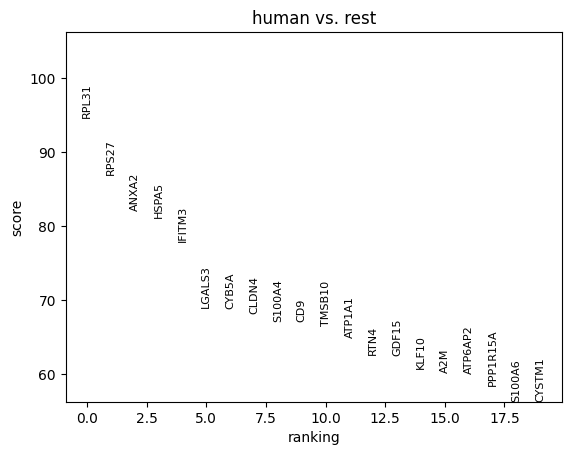

In [43]:
sc.tl.rank_genes_groups(
    toc, groupby="organism", method="t-test_overestim_var", groups=["human"]
)
sc.pl.rank_genes_groups(toc)  # ,

In [44]:
# Create a dictionary or pandas Series with genes and their scores
gene_names = [i[0] for i in toc.uns["rank_genes_groups"]["names"]]
gene_scores = [i[0] for i in toc.uns["rank_genes_groups"]["scores"]]
rnk = pd.Series(gene_scores, index=gene_names)

In [45]:
rnk[:10]

RPL31     94.691521
RPS27     86.879005
ANXA2     82.019341
HSPA5     81.187111
IFITM3    77.856049
LGALS3    68.944298
CYB5A     68.820351
CLDN4     68.130074
S100A4    67.107536
CD9       67.075294
dtype: float32

In [46]:
rnk[-10:]

TMEM92     -62.668350
CTSL       -70.975273
TMSB15A    -78.232567
CD300LF    -79.326996
CYB5D2     -81.787590
HSPA12B    -86.231186
IFITM10    -87.404861
RPS6KA2    -91.495667
S1PR5      -95.398651
RPL3L     -144.974152
dtype: float32

In [49]:
enr = gp.prerank(
    rnk=rnk,
    gene_sets=[
        "GO_Molecular_Function_2023"
    ],  # , 'MSigDB_Hallmark_2020', 'Reactome_2022', 'Tabula_Sapiens', 'WikiPathway_2023_Human', 'TF_Perturbations_Followed_by_Expression', 'PPI_Hub_Proteins', 'OMIM_Disease', 'GO_Molecular_Function_2023'],
    organism="Human",  # change accordingly
    # description='pathway',
    cutoff=0.05,  # test dataset, use lower value for real case
    background=mouse.var.index.tolist(),
)
enr.res2d[enr.res2d["FDR q-val"] < 0.1].head(20)

2025-11-12 14:50:52,640 [WARNING] Duplicated values found in preranked stats: 0.58% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,GO_Molecular_Function_2023__Cadherin Binding (...,0.548011,1.968874,0.0,0.023772,0.017,18/75,10.48%,ANXA2;HSPA5;RTN4;KRT18;S100A11;EPCAM;HSPA1A;IT...
1,prerank,GO_Molecular_Function_2023__Cell-Cell Adhesion...,0.69749,1.933498,0.0,0.021791,0.03,4/21,0.72%,ANXA2;KRT18;S100A11;EPCAM
2,prerank,GO_Molecular_Function_2023__DNA-binding Transc...,0.493233,1.887827,0.0,0.021131,0.043,28/110,13.89%,KLF10;KLF4;KLF6;ATF3;SOX4;HIF1A;ELF3;NR4A2;DDI...
3,prerank,GO_Molecular_Function_2023__Ubiquitin Protein ...,0.533725,1.873761,0.001742,0.01948,0.052,25/66,15.81%,HSPA5;RTN4;HSPA1A;HIF1A;HSP90AA1;CXCR4;TRIB1;C...
4,prerank,GO_Molecular_Function_2023__Ubiquitin-Like Pro...,0.519537,1.826716,0.001779,0.029847,0.095,25/68,15.81%,HSPA5;RTN4;HSPA1A;HIF1A;HSP90AA1;CXCR4;TRIB1;C...


- Reactome_2022\_\_Collagen Biosynthesis And Modif...
- Reactome_2022\_\_Collagen Formation R-HSA-1474290
- Reactome_2022\_\_Extracellular Matrix Organizati...
- Reactome_2022\_\_Plasma Lipoprotein Remodeling R...
- Reactome_2022\_\_Collagen Chain Trimerization R-...
- Reactome_2022\_\_Diseases Associated With Glycos...
- Reactome_2022\_\_ECM Proteoglycans R-HSA-3000178
- Reactome_2022\_\_Plasma Lipoprotein Assembly, Re...
- Reactome_2022\_\_Assembly Of Collagen Fibrils An...
- Reactome_2022\_\_Retinoid Metabolism And Transpo...
- Reactome_2022\_\_Metabolism Of Fat-Soluble Vitam...
- Reactome_2022\_\_Collagen Degradation R-HSA-1442490
- Reactome_2022\_\_Immunoregulatory Interactions B...
- MSigDB_Hallmark_2020\_\_TNF-alpha Signaling via ...
- MSigDB_Hallmark_2020\_\_Estrogen Response Early
- MSigDB_Hallmark_2020\_\_Apoptosis
- MSigDB_Hallmark_2020\_\_Cholesterol Homeostasis
- MSigDB_Hallmark_2020\_\_Hypoxia
- MSigDB_Hallmark_2020\_\_KRAS Signaling Up
- MSigDB_Hallmark_2020\_\_DNA Repair
- MSigDB_Hallmark_2020\_\_mTORC1 Signaling
- MSigDB_Hallmark_2020\_\_p53 Pathway
- MSigDB_Hallmark_2020\_\_Myc Targets V1
- MSigDB_Hallmark_2020\_\_UV Response Up
- MSigDB_Hallmark_2020\_\_Epithelial Mesenchymal T...
- MSigDB_Hallmark_2020\_\_Androgen Response
- MSigDB_Hallmark_2020\_\_Inflammatory Response
- MSigDB_Hallmark_2020\_\_Allograft Rejection
- MSigDB_Hallmark_2020\_\_UV Response Dn
- MSigDB_Hallmark_2020\_\_Unfolded Protein Response
- MSigDB_Hallmark_2020\_\_Estrogen Response Late
- MSigDB_Hallmark_2020\_\_IL-2/STAT5 Signaling
- MSigDB_Hallmark_2020\_\_IL-6/JAK/STAT3 Signaling
-
- GO_Molecular_Function_2023\_\_Cadherin Binding (...
- GO_Molecular_Function_2023\_\_Cell-Cell Adhesion.
- GO_Molecular_Function_2023\_\_DNA-binding Transc.
- GO_Molecular_Function_2023\_\_Ubiquitin Protein ...
- GO_Molecular_Function_2023\_\_Ubiquitin-Like Pro.


## fake human and mouse


In [56]:
toc = ad.concat([pred, mouse], label="organism", merge="same")
toc.obs = toc.obs.replace({"organism": {"0": "as_human", "1": "mouse"}})
toc.var.set_index("symbol", inplace=True)

/local/scratch/tmp/ipykernel_994470/3687006840.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  toc.obs = toc.obs.replace({"organism": {"0": "as_human", "1": "mouse"}})


In [57]:
# full diff expr
sc.pp.normalize_total(toc, target_sum=1e4)
sc.pp.log1p(toc)

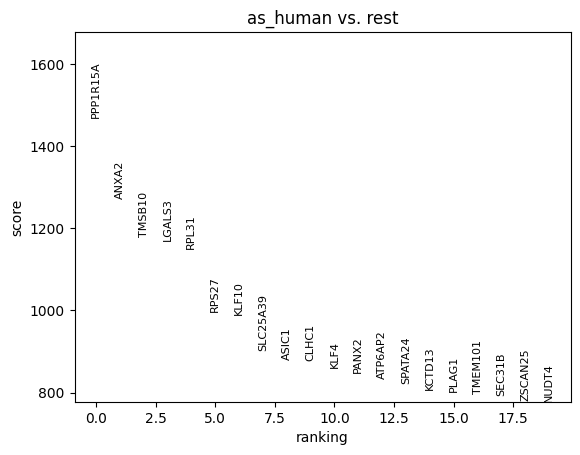

In [59]:
sc.tl.rank_genes_groups(
    toc, groupby="organism", method="t-test_overestim_var", groups=["as_human"]
)
sc.pl.rank_genes_groups(toc)

In [ ]:
# Create a dictionary or pandas Series with genes and their scores
gene_names = [i[0] for i in toc.uns["rank_genes_groups"]["names"]]
gene_scores = [i[0] for i in toc.uns["rank_genes_groups"]["scores"]]
rnk_pred = pd.Series(gene_scores, index=gene_names)

In [ ]:
rnk_pred[:10]

PPP1R15A    1470.686035
ANXA2       1272.249023
TMSB10      1180.823242
LGALS3      1169.809204
RPL31       1149.736694
RPS27        995.858521
KLF10        990.572266
SLC25A39     902.350769
ASIC1        880.868835
CLHC1        877.790466
dtype: float32

In [ ]:
rnk_pred[-10:]

COL4A5     -50.195354
TMEM92     -61.911270
CD300LF    -84.175621
HSPA12B    -87.052628
TMSB15A    -97.206764
RPS6KA2    -98.302513
IFITM10   -102.752335
CYB5D2    -107.414589
S1PR5     -131.424515
RPL3L     -187.869110
dtype: float32

In [ ]:
enr.res2d

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Reactome_2022__Immunoregulatory Interactions B...,-0.259724,-3.127675,0.0,0.0,0.0,54/54,74.33%,CD300LF;CD226;CLEC4G;CD160;FCGR2B;TYROBP;CD300...
1,prerank,Reactome_2022__Response Of EIF2AK4 (GCN2) To A...,0.659302,2.027215,0.0,0.027391,0.027,4/15,3.51%,RPL31;RPS27;GCN1;GDNF
2,prerank,Reactome_2022__Non-integrin membrane-ECM Inter...,-0.299496,-1.933965,0.0,0.072589,0.03006,25/25,70.22%,SDC3;TTR;SDC1;SDC4;AGRN;LAMC1;LAMA4;DAG1;DDR2;...
3,prerank,Reactome_2022__Molecules Associated With Elast...,-0.387447,-1.928669,0.0,0.048393,0.03006,19/19,61.42%,MFAP5;LTBP4;FBLN5;BMP2;FBLN1;MFAP4;MFAP2;TGFB3...
4,prerank,Reactome_2022__Potassium Channels R-HSA-1296071,0.527618,1.875464,0.001012,0.10637,0.18,13/31,12.71%,KCNMB3;KCND3;KCNH7;KCNQ2;KCNF1;KCNH6;KCNQ5;KCN...
...,...,...,...,...,...,...,...,...,...,...
390,prerank,Reactome_2022__Extracellular Matrix Organizati...,0.082098,0.350987,1.0,1.0,1.0,58/167,47.21%,COL4A6;CAPN12;ITGA5;MMP24;P4HA3;LOXL4;COL27A1;...
391,prerank,Reactome_2022__Antimicrobial Peptides R-HSA-68...,0.099502,0.335656,0.997949,1.0,1.0,17/24,77.72%,ITLN1;PGLYRP2;BPIFA2;LEAP2;BPI;REG3G;CD4;PRTN3...
392,prerank,Reactome_2022__Innate Immune System R-HSA-168249,0.073105,0.325211,1.0,1.0,1.0,8/316,2.55%,ANXA2;LGALS3;ATP6AP2;HSPA1A;MAPK8;PTPRN2;NANOS...
393,prerank,Reactome_2022__Metabolism Of Vitamins And Cofa...,0.080942,0.325047,1.0,1.0,1.0,52/79,75.05%,CYB5A;SLC52A3;SLC46A1;GPC5;CD320;SLC23A1;TACR1...


In [90]:
enr = gp.prerank(
    rnk=rnk_pred,
    gene_sets=[
        "Reactome_2022"
    ],  # , 'MSigDB_Hallmark_2020', 'Reactome_2022', 'Tabula_Sapiens', 'WikiPathway_2023_Human', 'TF_Perturbations_Followed_by_Expression', 'PPI_Hub_Proteins', 'OMIM_Disease', 'GO_Molecular_Function_2023'],
    organism="Human",  # change accordingly
    # description='pathway',
    cutoff=0.05,  # test dataset, use lower value for real case
    background=mouse.var.index.tolist(),
)
enr.res2d[enr.res2d["FDR q-val"] < 0.1].head(20)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Reactome_2022__Immunoregulatory Interactions B...,-0.259724,-3.127675,0.0,0.0,0.0,54/54,74.33%,CD300LF;CD226;CLEC4G;CD160;FCGR2B;TYROBP;CD300...
1,prerank,Reactome_2022__Response Of EIF2AK4 (GCN2) To A...,0.659302,2.027215,0.0,0.027391,0.027,4/15,3.51%,RPL31;RPS27;GCN1;GDNF
2,prerank,Reactome_2022__Non-integrin membrane-ECM Inter...,-0.299496,-1.933965,0.0,0.072589,0.03006,25/25,70.22%,SDC3;TTR;SDC1;SDC4;AGRN;LAMC1;LAMA4;DAG1;DDR2;...
3,prerank,Reactome_2022__Molecules Associated With Elast...,-0.387447,-1.928669,0.0,0.048393,0.03006,19/19,61.42%,MFAP5;LTBP4;FBLN5;BMP2;FBLN1;MFAP4;MFAP2;TGFB3...
5,prerank,Reactome_2022__Major Pathway Of rRNA Processin...,0.541859,1.869575,0.002066,0.075783,0.188,10/24,19.92%,RPL31;RPS27;WDR43;TEX10;WDR12;DIS3;NOL9;UTP4;H...
6,prerank,Reactome_2022__rRNA Processing In Nucleus And ...,0.520154,1.817531,0.003077,0.084913,0.3,10/25,19.92%,RPL31;RPS27;WDR43;TEX10;WDR12;DIS3;NOL9;UTP4;H...
7,prerank,Reactome_2022__rRNA Processing R-HSA-72312,0.520154,1.817531,0.003077,0.084913,0.3,10/25,19.92%,RPL31;RPS27;WDR43;TEX10;WDR12;DIS3;NOL9;UTP4;H...


Name Term ES NES NOM p-val FDR q-val FWER p-val Tag % Gene % Lead_genes

- Reactome_2022\_\_Immunoregulatory Interactions B...
- Reactome_2022\_\_Response Of EIF2AK4 (GCN2) To A...
- Reactome_2022\_\_Non-integrin membrane-ECM Inter...
- Reactome_2022\_\_Molecules Associated With Elast...
- Reactome_2022\_\_Major Pathway Of rRNA Processin...
- Reactome_2022\_\_rRNA Processing In Nucleus And ...
- Reactome_2022\_\_rRNA Processing R-HSA-72312
- MSigDB_Hallmark_2020\_\_Reactive Oxygen Species ...
- MSigDB_Hallmark_2020\_\_Myc Targets V1
- GO_Molecular_Function_2023\_\_Voltage-Gated Mono...
- GO_Molecular_Function_2023\_\_Potassium Channel ...
- GO_Molecular_Function_2023\_\_Calcium Channel Ac...
- GO_Molecular_Function_2023\_\_Monoatomic Cation ...
- GO_Molecular_Function_2023\_\_Calcium Ion Transm...
- GO_Molecular_Function_2023\_\_Voltage-Gated Calc...
- GO_Molecular_Function_2023\_\_Hormone Activity (...


In [ ]:
enr = (
    enr.res2d
)  # = enr.res2d['Term'].str.replace("GO_Molecular_Function_2023__:", "").replace(' Activity ', '').values

In [ ]:
enr.loc[:, "Term"] = (
    enr["Term"]
    .str.replace("GO_Molecular_Function_2023__", "")
    .str.replace(" Activity ", "")
)

In [ ]:
enr.loc[:, "Term"] = enr["Term"].str.replace("Reactome_2022__", "").str[:-10]

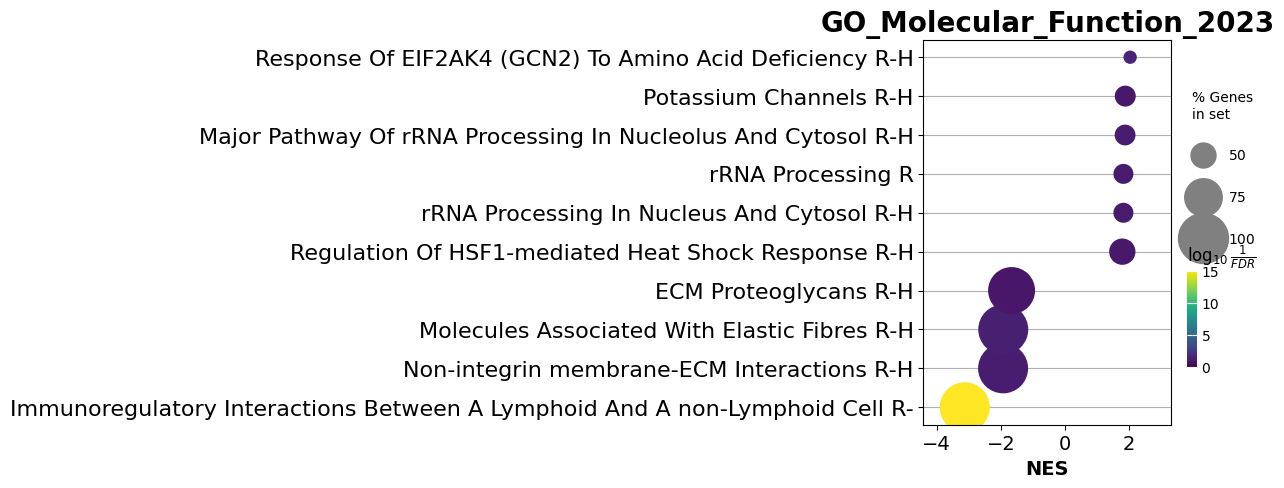

In [ ]:
from gseapy import dotplot

# to save your figure, make sure that ``ofname`` is not None
ax = dotplot(
    enr,
    column="FDR q-val",
    title="GO_Molecular_Function_2023",
    cmap=plt.cm.viridis,
    size=6,  # adjust dot size
    figsize=(4, 5),
    cutoff=0.25,
    show_ring=False,
)

## the two of them


In [ ]:
TOP = 50
len(set(rnk[:TOP].index) & set(rnk_pred[:TOP].index)) / TOP

0.18

In [ ]:
# mouse turned as human vs mouse
Reactome_2022_Cellular Response To Starvation...
Reactome_2022 Protein Localization R-HSA-960950
Blood Thymus
bone marrow, b cell, t cell, macrophave, myeloid progenitor
Human_Striated muscle
contraction
myopathi
cardiomyopathy

# mouse vs human
Reactome_2022__Collagen
ECM, proteoglycans
UBIquitin, RNA pol
DNA TF binding, cell cell adhesion some nuclear, glucocorticoid receptor

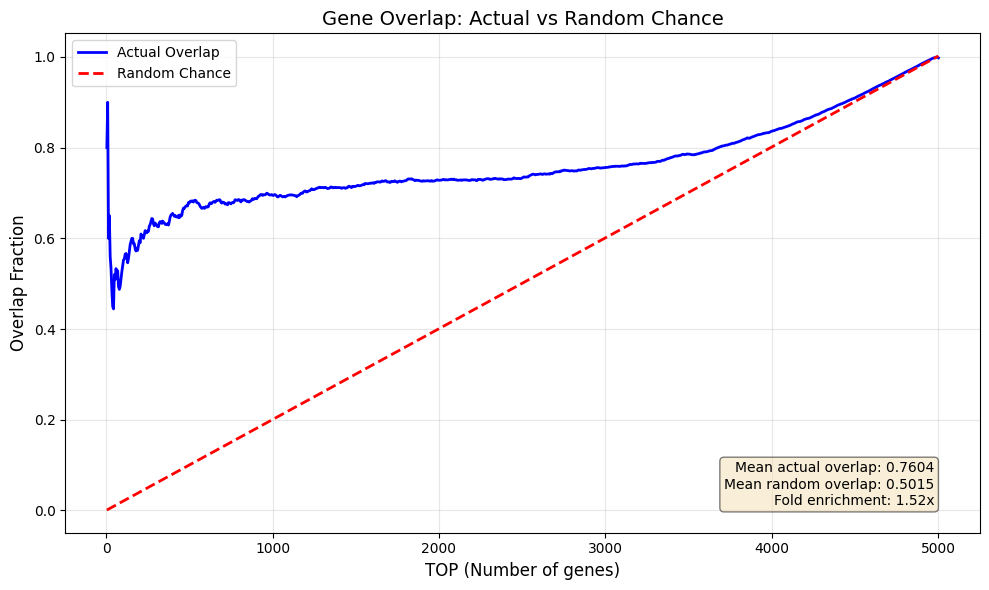

In [52]:
import matplotlib.pyplot as plt

# Test different TOP values
top_values = range(5, 5001, 5)
overlaps = []
random_overlaps = []

total_genes = len(rnk)

for TOP in top_values:
    # Calculate actual overlap
    actual_overlap = (
        len(set(rnk[::-1][:TOP].index) & set(rnk_pred[::-1][:TOP].index)) / TOP
    )
    overlaps.append(actual_overlap)

    # Calculate expected overlap by random chance
    # P(overlap) = TOP / total genes for each gene
    random_overlap = TOP / total_genes
    random_overlaps.append(random_overlap)
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(top_values, overlaps, label="Actual Overlap", linewidth=2, color="blue")
plt.plot(
    top_values,
    random_overlaps,
    label="Random Chance",
    linewidth=2,
    linestyle="--",
    color="red",
)
# Add text to the plot
plt.text(
    0.95,
    0.05,
    f"Mean actual overlap: {np.mean (overlaps):.4f}\n"
    f"Mean random overlap: {np.mean (random_overlaps):.4f}\n"
    f"Fold enrichment: {np.mean (overlaps) / np.mean (random_overlaps):.2f}x",
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="bottom",
    horizontalalignment="right",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)
plt.xlabel("TOP (Number of genes)", fontsize=12)
plt.ylabel("Overlap Fraction", fontsize=12)
plt.title("Gene Overlap: Actual vs Random Chance", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

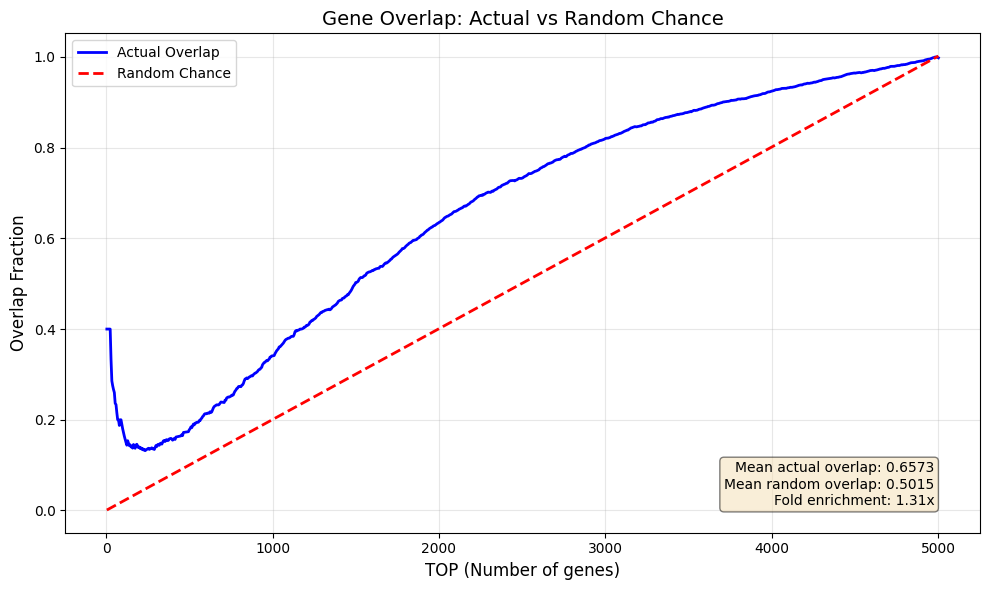

In [53]:
import matplotlib.pyplot as plt

# Test different TOP values
top_values = range(5, 5001, 5)
overlaps = []
random_overlaps = []

total_genes = len(rnk)

for TOP in top_values:
    # Calculate actual overlap
    actual_overlap = len(set(rnk[:TOP].index) & set(rnk_pred[:TOP].index)) / TOP
    overlaps.append(actual_overlap)

    # Calculate expected overlap by random chance
    # P(overlap) = TOP / total genes for each gene
    random_overlap = TOP / total_genes
    random_overlaps.append(random_overlap)
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(top_values, overlaps, label="Actual Overlap", linewidth=2, color="blue")
plt.plot(
    top_values,
    random_overlaps,
    label="Random Chance",
    linewidth=2,
    linestyle="--",
    color="red",
)
# Add text to the plot
plt.text(
    0.95,
    0.05,
    f"Mean actual overlap: {np.mean (overlaps):.4f}\n"
    f"Mean random overlap: {np.mean (random_overlaps):.4f}\n"
    f"Fold enrichment: {np.mean (overlaps) / np.mean (random_overlaps):.2f}x",
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="bottom",
    horizontalalignment="right",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)
plt.xlabel("TOP (Number of genes)", fontsize=12)
plt.ylabel("Overlap Fraction", fontsize=12)
plt.title("Gene Overlap: Actual vs Random Chance", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
TOP = 50

In [96]:
names = np.array([i[0] for i in toc.uns["rank_genes_groups"]["names"]])
p_vals = np.array([i[0] for i in toc.uns["rank_genes_groups"]["pvals_adj"]])
gene_scores = np.array([i[0] for i in toc.uns["rank_genes_groups"]["logfoldchanges"]])
genes_to_high = list(set(rnk[:TOP].index) & set(rnk_pred[:TOP].index)) + list(
    set(rnk[::-1][:TOP].index) & set(rnk_pred[::-1][:TOP].index)
)

In [97]:
volcda = pd.DataFrame(
    {"log2FoldChange": gene_scores, "pvalue": p_vals, "gene_id": gene_names},
    index=list(range(len(gene_names))),
)

In [98]:
volcano(volcda, tohighlight=genes_to_high, showlabels=True)

Unable to connect to VS Code server: Error in request.
Error: connect ENOENT /run/user/42151/vscode-ipc-7fc6f6e2-119c-4f39-a55f-0f2ec17da7cc.sock
    at PipeConnectWrap.afterConnect [as oncomplete] (node:net:1637:16) {
  errno: -2,
  code: 'ENOENT',
  syscall: 'connect',
  address: '/run/user/42151/vscode-ipc-7fc6f6e2-119c-4f39-a55f-0f2ec17da7cc.sock'
}


figure(id='p1004', ...)

# The same thing but for male -> female


In [102]:
mouse.obs["pred_sex_ontology_term_id"].value_counts()

pred_sex_ontology_term_id
PATO:0000384    8924
PATO:0000383    1076
Name: count, dtype: int64

In [101]:
human.obs["pred_sex_ontology_term_id"].value_counts()

pred_sex_ontology_term_id
PATO:0000384    7369
PATO:0000383    2631
Name: count, dtype: int64

In [ ]:
n_adata.obsm["scprint_emb_sex_ontology_term_id"] = np.tile(
    n_adata[n_adata.obs["pred_sex_ontology_term_id"] == "PATO:0000383"]
    .obsm["scprint_emb_sex_ontology_term_id"]
    .mean(0),
    (n_adata.shape[0], 1),
)

In [106]:
generator = Generate(genelist=genes, batch_size=32)
pred = generator(
    model, n_adata[n_adata.obs["pred_sex_ontology_term_id"] == "PATO:0000384"]
)

not on wandb, could not set name


100%|██████████| 1078/1078 [15:43<00:00,  1.14it/s]


In [ ]:
# diff expr analysis

In [107]:
res = ot.solve_sample(
    torch.Tensor(pred.X).to(device="cuda"),
    torch.Tensor(
        human[human.obs["pred_sex_ontology_term_id"] == "PATO:0000383"].X.todense()
    ).to(device="cuda"),
    reg=0.1,
)
res.value

tensor(937.6122, device='cuda:0')

In [108]:
res = ot.solve_sample(
    torch.Tensor(
        human[human.obs["pred_sex_ontology_term_id"] == "PATO:0000383"].X.todense()
    ).to(device="cuda"),
    torch.Tensor(
        human[human.obs["pred_sex_ontology_term_id"] == "PATO:0000384"].X.todense()
    ).to(device="cuda"),
    reg=0.1,
)
res.value

tensor(1075.8657, device='cuda:0')

In [109]:
pred.var = human.var.copy()

### human mouse


In [110]:
toc = ad.concat(
    [
        human[human.obs["pred_sex_ontology_term_id"] == "PATO:0000384"],
        human[human.obs["pred_sex_ontology_term_id"] == "PATO:0000383"],
    ],
    label="sex",
    merge="same",
)
toc.obs = toc.obs.replace({"sex": {"0": "male", "1": "female"}})
toc.var.set_index("symbol", inplace=True)

/local/scratch/tmp/ipykernel_994470/2265475646.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  toc.obs = toc.obs.replace({"sex": {"0": "male", "1": "female"}})


In [111]:
# full diff expr
sc.pp.normalize_total(toc, target_sum=1e4)
sc.pp.log1p(toc)

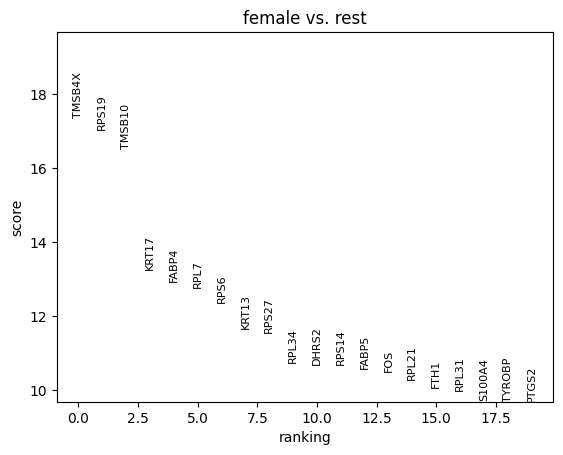

In [112]:
sc.tl.rank_genes_groups(
    toc, groupby="sex", method="t-test_overestim_var", groups=["female"]
)
sc.pl.rank_genes_groups(toc)  # ,

In [113]:
# Create a dictionary or pandas Series with genes and their scores
gene_names = [i[0] for i in toc.uns["rank_genes_groups"]["names"]]
gene_scores = [i[0] for i in toc.uns["rank_genes_groups"]["scores"]]
rnk = pd.Series(gene_scores, index=gene_names)

In [114]:
rnk[:10]

TMSB4X    17.371428
RPS19     17.044052
TMSB10    16.534336
KRT17     13.243579
FABP4     12.919654
RPL7      12.759441
RPS6      12.368764
KRT13     11.653184
RPS27     11.546421
RPL34     10.728844
dtype: float32

In [115]:
rnk[-10:]

FXYD2     -12.434738
CYSTM1    -12.436889
CLDN10    -12.463648
EPCAM     -12.927284
SLC12A1   -14.013198
MAL       -14.129655
SPP1      -14.177118
MMP7      -15.881151
WFDC2     -18.240456
DEFB1     -18.729858
dtype: float32

In [118]:
enr = gp.prerank(
    rnk=rnk,
    gene_sets=[
        "Reactome_2022"
    ],  # , 'MSigDB_Hallmark_2020', 'Reactome_2022', 'Tabula_Sapiens', 'WikiPathway_2023_Human', 'TF_Perturbations_Followed_by_Expression', 'PPI_Hub_Proteins', 'OMIM_Disease', 'GO_Molecular_Function_2023'],
    organism="Human",  # change accordingly
    # description='pathway',
    cutoff=0.05,  # test dataset, use lower value for real case
    background=human.var.index.tolist(),
)
enr.res2d[enr.res2d["FDR q-val"] < 0.1].head(20)

2025-11-12 16:59:40,137 [WARNING] Duplicated values found in preranked stats: 1.96% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Reactome_2022__rRNA Processing R-HSA-72312,0.844988,2.638043,0.0,0.0,0.0,8/25,0.34%,RPS19;RPL7;RPS6;RPS27;RPL34;RPS14;RPL21;RPL31
1,prerank,Reactome_2022__rRNA Processing In Nucleus And ...,0.844988,2.638043,0.0,0.0,0.0,8/25,0.34%,RPS19;RPL7;RPS6;RPS27;RPL34;RPS14;RPL21;RPL31
2,prerank,Reactome_2022__Regulation Of Expression Of SLI...,0.860679,2.605774,0.0,0.0,0.0,10/21,4.37%,RPS19;RPL7;RPS6;RPS27;RPL34;RPS14;RPL21;RPL31;...
3,prerank,Reactome_2022__Major Pathway Of rRNA Processin...,0.847608,2.605609,0.0,0.0,0.0,8/24,0.34%,RPS19;RPL7;RPS6;RPS27;RPL34;RPS14;RPL21;RPL31
4,prerank,Reactome_2022__Influenza Viral RNA Transcripti...,0.931171,2.577135,0.0,0.0,0.0,8/15,0.34%,RPS19;RPL7;RPS6;RPS27;RPL34;RPS14;RPL21;RPL31
5,prerank,Reactome_2022__Signaling By ROBO Receptors R-H...,0.739734,2.507469,0.0,0.0,0.0,11/34,4.37%,RPS19;RPL7;RPS6;RPS27;RPL34;RPS14;RPL21;RPL31;...
6,prerank,Reactome_2022__Immunoregulatory Interactions B...,0.678755,2.486835,0.0,0.0,0.0,29/54,9.42%,TYROBP;B2M;KLRB1;ITGB2;CD3D;CLEC1B;JAML;CLEC4G...
7,prerank,Reactome_2022__Influenza Infection R-HSA-168255,0.876579,2.48593,0.0,0.0,0.0,8/18,0.34%,RPS19;RPL7;RPS6;RPS27;RPL34;RPS14;RPL21;RPL31
8,prerank,Reactome_2022__Translation R-HSA-72766,0.834156,2.374263,0.0,0.0,0.0,8/18,0.34%,RPS19;RPL7;RPS6;RPS27;RPL34;RPS14;RPL21;RPL31
9,prerank,Reactome_2022__Selenoamino Acid Metabolism R-H...,0.792442,2.349999,0.0,0.0,0.0,9/20,3.49%,RPS19;RPL7;RPS6;RPS27;RPL34;RPS14;RPL21;RPL31;...


- Cytokine Receptor ...
- Ligand-Gated Monoa...
- Allograft Rejection
- Oxidative Phosphorylation -
- E2F Targets
- Inflammatory Response
- Complement
- Angiogenesis
- rRNA Processing R-HSA-72312
- rRNA Processing In Nucleus And ...
- Regulation Of Expression Of SLI...
- Major Pathway Of rRNA Processin...
- Influenza Viral RNA Transcripti...
- Signaling By ROBO Receptors R-H...
- Immunoregulatory Interactions B...
- Influenza Infection R-HSA-168255
- Translation R-HSA-72766
- Selenoamino Acid Metabolism R-H...
- Metabolism Of RNA R-HSA-8953854
- Unattached Kinetochores Signal ...
- EML4 And NUDC In Mitotic Spindl...
- Resolution Of Sister Chromatid ...
- Mitotic Prometaphase R-HSA-68877
- Arachidonic Acid Metabolism R-H...


In [ ]:
toc = ad.concat(
    [human[human.obs["pred_sex_ontology_term_id"] == "PATO:0000384"], pred],
    label="sex",
    merge="same",
)
toc.obs = toc.obs.replace({"sex": {"0": "male", "1": "as_female"}})
toc.var.set_index("symbol", inplace=True)

In [120]:
# full diff expr
sc.pp.normalize_total(toc, target_sum=1e4)
sc.pp.log1p(toc)

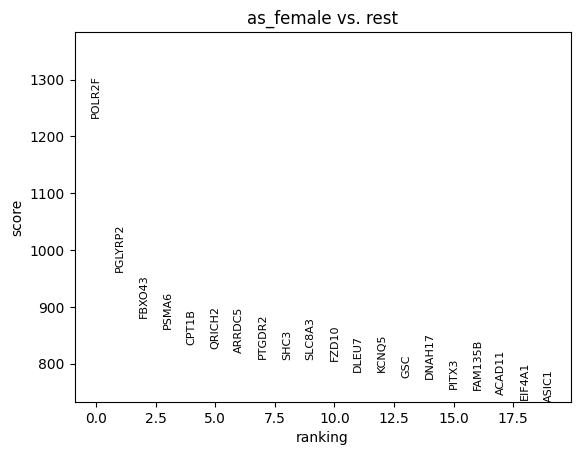

In [128]:
sc.tl.rank_genes_groups(
    toc, groupby="sex", method="t-test_overestim_var", groups=["as_female"]
)
sc.pl.rank_genes_groups(toc)

In [129]:
# Create a dictionary or pandas Series with genes and their scores
gene_names = [i[0] for i in toc.uns["rank_genes_groups"]["names"]]
gene_scores = [i[0] for i in toc.uns["rank_genes_groups"]["scores"]]
rnk_pred = pd.Series(gene_scores, index=gene_names)

In [130]:
rnk_pred[:10]

POLR2F     1233.448120
PGLYRP2     961.866394
FBXO43      880.874512
PSMA6       862.351685
CPT1B       833.152588
QRICH2      825.589355
ARRDC5      819.106384
PTGDR2      807.916382
SHC3        807.393005
SLC8A3      806.570190
dtype: float32

In [131]:
rnk_pred[-10:]

POU3F3      13.786296
SLC4A1      12.018818
WFDC2       11.351852
NR0B2        5.916065
TSPAN1       2.426702
S100A2      -4.625795
LDHB        -5.245252
CLDN4       -9.145508
SPP1       -11.398892
ATP6V1G3   -14.004469
dtype: float32

In [137]:
enr = gp.prerank(
    rnk=rnk_pred,
    gene_sets=[
        "GO_Molecular_Function_2023"
    ],  # , 'MSigDB_Hallmark_2020', 'Reactome_2022', 'Tabula_Sapiens', 'WikiPathway_2023_Human', 'TF_Perturbations_Followed_by_Expression', 'PPI_Hub_Proteins', 'OMIM_Disease', 'GO_Molecular_Function_2023'],
    organism="Human",  # change accordingly
    # description='pathway',
    cutoff=0.05,  # test dataset, use lower value for real case
    background=mouse.var.index.tolist(),
)
enr.res2d[enr.res2d["FDR q-val"] < 0.1].head(20)

2025-11-12 17:31:49,461 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,GO_Molecular_Function_2023__Voltage-Gated Pota...,0.557057,2.179235,0.0,0.005683,0.006,14/28,16.17%,KCNQ5;KCNJ2;KCNH7;KCNK2;KCNF1;LRRC26;KCNE1;KCN...
1,prerank,GO_Molecular_Function_2023__Potassium Channel ...,0.555812,2.125189,0.0,0.007577,0.015,13/24,16.17%,KCNQ5;KCNK7;KCNK2;KCNF1;KCNK3;KCNMB3;LRRC26;KC...
2,prerank,GO_Molecular_Function_2023__Voltage-Gated Mono...,0.520025,1.96879,0.00107,0.030307,0.085,12/22,17.94%,KCNQ5;CATSPER3;KCNF1;LRRC26;KCNE1;KCNMA1;KCNQ2...
3,prerank,GO_Molecular_Function_2023__Ligand-Gated Monoa...,0.494631,1.923802,0.001035,0.03741,0.134,9/26,9.42%,TRPM8;KCNJ2;KCNH7;CHRNA4;CHRNA1;CHRNA7;KCNH6;C...
4,prerank,GO_Molecular_Function_2023__Hormone Activity (...,0.47687,1.90461,0.0,0.036368,0.158,24/30,41.96%,PTHLH;NPY;GAL;EDN3;CCK;PENK;POMC;PNOC;TRH;APLN...
5,prerank,GO_Molecular_Function_2023__Cytokine Activity ...,0.400616,1.893644,0.0,0.034569,0.181,49/75,40.92%,WNT5B;IL17D;WNT10B;WNT11;WNT2;LEFTY2;INHBE;GDF...
6,prerank,GO_Molecular_Function_2023__Monoatomic Cation ...,0.469478,1.884256,0.001018,0.032336,0.198,11/32,8.00%,TRPM8;SLC24A3;PKD1L2;PKD2L2;KCNK7;KCNF1;KCNK3;...
7,prerank,GO_Molecular_Function_2023__Calcium Channel Ac...,0.449736,1.814331,0.003115,0.05943,0.379,15/30,22.42%,TRPM8;SLC24A3;PKD1L2;PKD2L2;CATSPER3;CHRNA7;TR...
8,prerank,GO_Molecular_Function_2023__Receptor Ligand Ac...,0.351358,1.804229,0.0,0.058298,0.403,88/143,41.96%,GDNF;WNT5B;IL17D;WNT10B;WNT11;WNT2;LEFTY2;INHB...
9,prerank,GO_Molecular_Function_2023__Channel Activity (...,0.471162,1.743444,0.012973,0.092625,0.594,8/20,17.39%,CHRNA1;GSDMA;KCNK3;CHRNA7;TRPA1;PDPN;MCUB;AQP4


Name Term ES NES NOM p-val FDR q-val FWER p-val Tag % Gene % Lead_genes

- DAP12 Interactions R-HSA-2172127
- Signaling By PDGF R-HSA-186797
- Potassium Channels R-HSA-1296071
- RAC2 GTPase Cycle R-HSA-9013404
- FCGR3A-mediated Phagocytosis R-HSA-9013404
- Interferon Gamma Response
- Apoptosis
- Voltage-Gated Pota...
- Potassium Channel ...
- Voltage-Gated Mono...
- Ligand-Gated Monoa...
- Hormone Activity (...
- Cytokine Activity ...
- onoatomic Cation ...
- Calcium Channel Ac...
- Receptor Ligand Ac...
- Channel Activity (...


In [ ]:
enr = (
    enr.res2d
)  # = enr.res2d['Term'].str.replace("GO_Molecular_Function_2023__:", "").replace(' Activity ', '').values

In [ ]:
enr.loc[:, "Term"] = (
    enr["Term"]
    .str.replace("GO_Molecular_Function_2023__", "")
    .str.replace(" Activity ", "")
)

In [ ]:
enr.loc[:, "Term"] = enr["Term"].str.replace("Reactome_2022__", "").str[:-10]

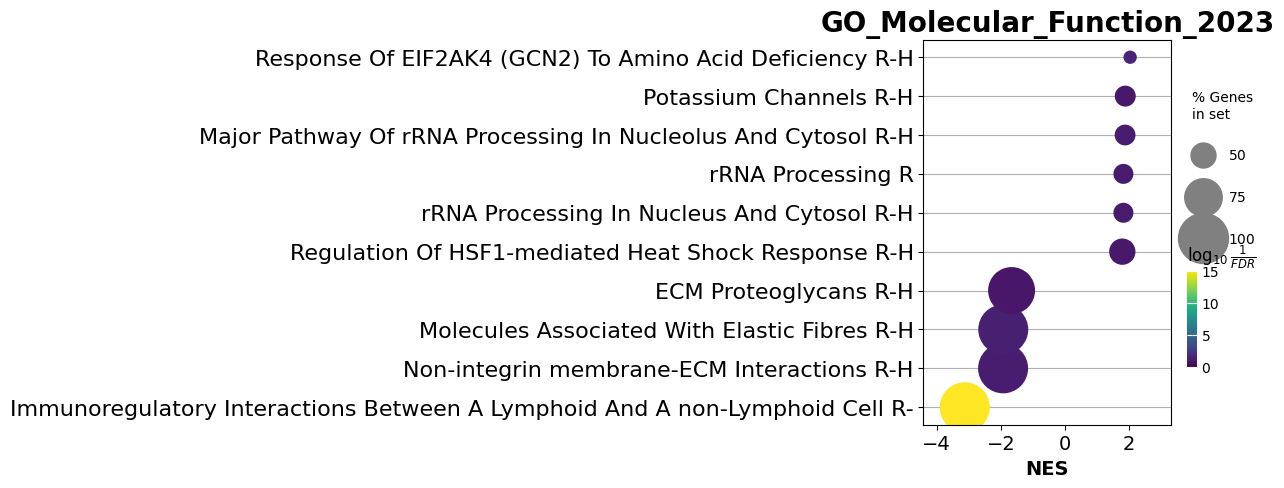

In [ ]:
from gseapy import dotplot

# to save your figure, make sure that ``ofname`` is not None
ax = dotplot(
    enr,
    column="FDR q-val",
    title="GO_Molecular_Function_2023",
    cmap=plt.cm.viridis,
    size=6,  # adjust dot size
    figsize=(4, 5),
    cutoff=0.25,
    show_ring=False,
)

In [134]:
TOP = 50
len(set(rnk[:TOP].index) & set(rnk_pred[:TOP].index)) / TOP

0.0

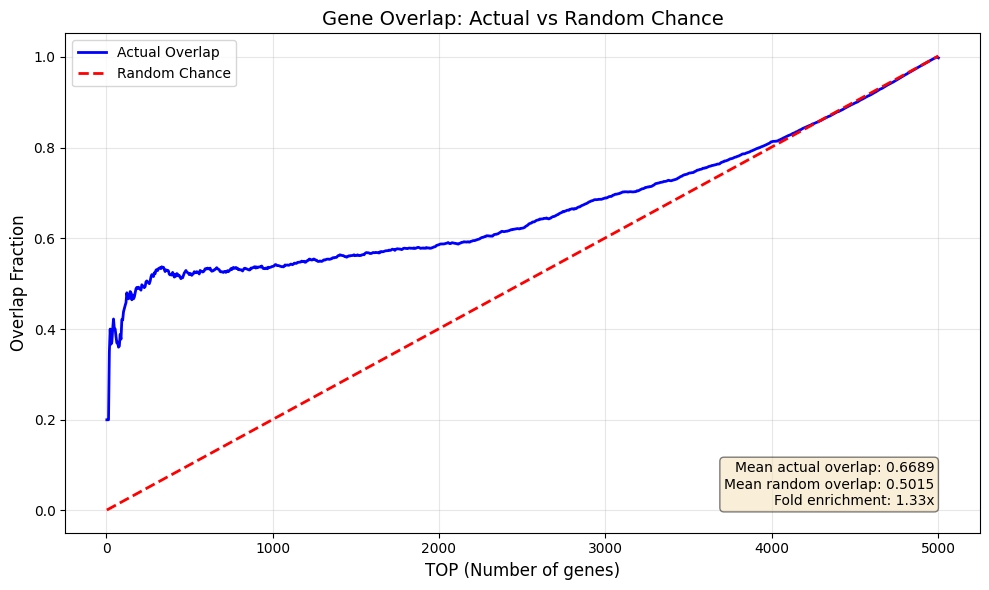

In [135]:
import matplotlib.pyplot as plt

# Test different TOP values
top_values = range(5, 5001, 5)
overlaps = []
random_overlaps = []

total_genes = len(rnk)

for TOP in top_values:
    # Calculate actual overlap
    actual_overlap = (
        len(set(rnk[::-1][:TOP].index) & set(rnk_pred[::-1][:TOP].index)) / TOP
    )
    overlaps.append(actual_overlap)

    # Calculate expected overlap by random chance
    # P(overlap) = TOP / total genes for each gene
    random_overlap = TOP / total_genes
    random_overlaps.append(random_overlap)
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(top_values, overlaps, label="Actual Overlap", linewidth=2, color="blue")
plt.plot(
    top_values,
    random_overlaps,
    label="Random Chance",
    linewidth=2,
    linestyle="--",
    color="red",
)
# Add text to the plot
plt.text(
    0.95,
    0.05,
    f"Mean actual overlap: {np.mean (overlaps):.4f}\n"
    f"Mean random overlap: {np.mean (random_overlaps):.4f}\n"
    f"Fold enrichment: {np.mean (overlaps) / np.mean (random_overlaps):.2f}x",
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="bottom",
    horizontalalignment="right",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)
plt.xlabel("TOP (Number of genes)", fontsize=12)
plt.ylabel("Overlap Fraction", fontsize=12)
plt.title("Gene Overlap: Actual vs Random Chance", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

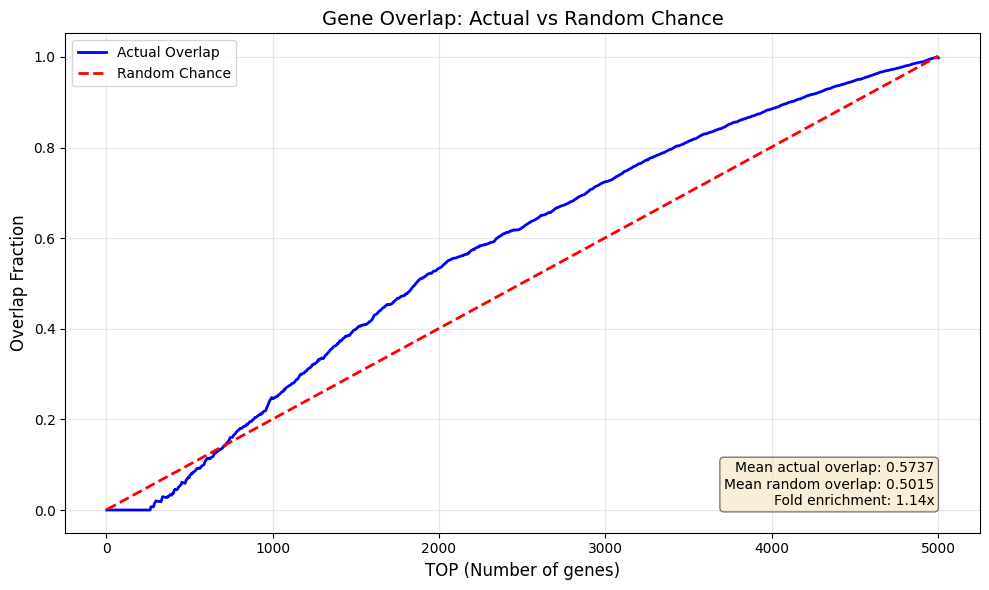

In [136]:
import matplotlib.pyplot as plt

# Test different TOP values
top_values = range(5, 5001, 5)
overlaps = []
random_overlaps = []

total_genes = len(rnk)

for TOP in top_values:
    # Calculate actual overlap
    actual_overlap = len(set(rnk[:TOP].index) & set(rnk_pred[:TOP].index)) / TOP
    overlaps.append(actual_overlap)

    # Calculate expected overlap by random chance
    # P(overlap) = TOP / total genes for each gene
    random_overlap = TOP / total_genes
    random_overlaps.append(random_overlap)
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(top_values, overlaps, label="Actual Overlap", linewidth=2, color="blue")
plt.plot(
    top_values,
    random_overlaps,
    label="Random Chance",
    linewidth=2,
    linestyle="--",
    color="red",
)
# Add text to the plot
plt.text(
    0.95,
    0.05,
    f"Mean actual overlap: {np.mean (overlaps):.4f}\n"
    f"Mean random overlap: {np.mean (random_overlaps):.4f}\n"
    f"Fold enrichment: {np.mean (overlaps) / np.mean (random_overlaps):.2f}x",
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="bottom",
    horizontalalignment="right",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)
plt.xlabel("TOP (Number of genes)", fontsize=12)
plt.ylabel("Overlap Fraction", fontsize=12)
plt.title("Gene Overlap: Actual vs Random Chance", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()